# Исследование непараметрических алгоритмов оценивания плотности распределения случайной величины

Вычислить абсолютную ошибку оценивания плотности распределения случайного вектора в двумерном пространстве признаков при использовании оценки Парзена. Построить график зависимости ошибки оценивания от величины параметра оконной функции. Используйте одну из следующих оконных функций: гауссовская функция c использованием диагональной матрицы

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import multivariate_normal

Гауссовская функция ядра имеет вид $K(u)= (2 \pi)^{-D/2} \exp(-1/2) $

In [2]:
def gauss_diag_kernel(x,train,h):
    n1,mx = x.shape
    n2,N = train.shape
    if n1==n2:
        n = n1
        fit = np.zeros([N,mx])
        for i in range(N):
            p_k = np.zeros([n,mx])
            mx_i = np.tile(XN[:,i].reshape(-1,1),[1,mx])
            ro = np.sum((x-mx_i)**2,0)
            fit[i,:] = np.exp(-ro/(2*h**2))/((2*np.pi)**(n/2)*(h**n))
        if N>1:
            p_ = np.sum(fit,0)/N
        else:
            p_ = fit
    return p_

In [3]:
N = 1000
n = 2
m = 3
ps=[0.2,0.2,0.6]
D=0.2
ro=-np.log(0.7)
m1=np.array([0,0])
m2=np.array([1,0])
m3=np.array([0,1])
m= [m1,m2,m3]

In [144]:
h_N = np.arange(0.1,0.5,0.01)

Неизвестное распределение представляет собой смесь 3 гауссиан размерности 2

In [145]:
C = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        C[i,j]=D*np.exp(-ro*abs(i-j))
x1 = np.arange(-2,3,0.1) 
x2 = np.arange(-2,3,0.1) 
X1,X2 = np.meshgrid(x1,x2) 
x = np.vstack((X1.ravel(),X2.ravel()))
x_ = x.T

p = ps[0] * multivariate_normal.pdf(x_,m1,C) + \
    ps[1] * multivariate_normal.pdf(x_,m2,C) + \
    ps[2] * multivariate_normal.pdf(x_,m3,C)
pi = np.reshape(p,(len(x1),len(x2)))

In [146]:
from numpy.linalg import LinAlgError
from numpy.linalg import cholesky
def randncor(n,N,C):
    try:
        A = cholesky(C)
    except LinAlgError:
        m=0
        print('A is not positive definite')
    m = n
    u = np.random.randn(m,N)
    x = A.conj().transpose().dot(u)
    return x 

In [147]:
# XN = np.zeros([n,N])
# h = h_N[j]
# for i in range(N):
#     u = np.random.randint(3)
#     XN[:,i] =(randncor(n,1,C) + m[u].reshape(-1,1)).T
# h_silverman =  1.06*np.std(XN)*N**(-1/5)
# p_ = gauss_diag_kernel(x,XN,h_silverman)
# pv = np.reshape(p_,(len(x1),len(x2)))

In [201]:
%%time
ks = []
for q in range(100): 
    errors = []
    pvs=[]
    XN = np.zeros([n,N])
    for i in range(N):
        u = np.random.randint(3)
        XN[:,i] =(randncor(n,1,C) + m[u].reshape(-1,1)).T
    h_silverman =  1.06*np.std(XN)*N**(-1/5)
    for j in range(len(h_N)):
        h = h_N[j]
        p_ = gauss_diag_kernel(x,XN,h)
        pv = np.reshape(p_,(len(x1),len(x2)))
        pvs.append(pv)
        err = np.sum(np.abs(pi-pv))
        errors.append(err)

    k = errors.index(min(errors))
    k = h_N[k]
    ks.append(k)

CPU times: user 7min 12s, sys: 248 ms, total: 7min 12s
Wall time: 7min 12s


In [ ]:
errors = []
    pvs=[]
    XN = np.zeros([n,N])
    for i in range(N):
        u = np.random.randint(3)
        XN[:,i] =(randncor(n,1,C) + m[u].reshape(-1,1)).T
    h_silverman =  1.06*np.std(XN)*N**(-1/5)

In [193]:
for j in range(len(h_N)):
    h = h_N[j]
    p_ = gauss_diag_kernel(x,XN,h)
    pv = np.reshape(p_,(len(x1),len(x2)))
    pvs.append(pv)
    err = np.sum(np.abs(pi-pv))
    errors.append(err)

In [ ]:
sum(ks)/len(ks)

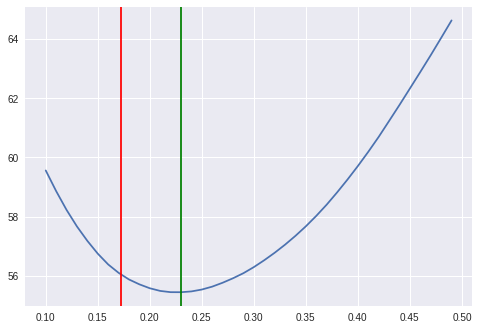

In [195]:
plt.plot(h_N,errors)
plt.axvline(s,c = 'r')
plt.axvline(k,c = 'g')

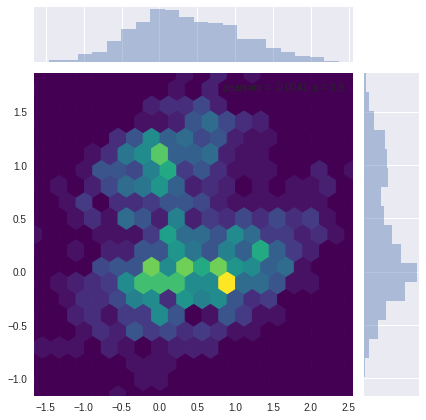

In [34]:
sns.jointplot(x=XN[0,:], y=XN[1,:], kind='hex',cmap = 'viridis')

In [37]:
def plot_2d_prob_density(X, Y, Z, xlabel='', ylabel='', ax=None, colorbar_lim=None, colorbar=True):
    from matplotlib import ticker
    # contourf accept vmin, vmax
    if ax is None:
        ax = plt.gca()
    CS = ax.contourf(X, Y, Z, 10, alpha=.75, cmap='viridis')
    ax.set_aspect('equal')
    if colorbar:
        cb = plt.colorbar(CS)
        tick_locator = ticker.MaxNLocator(nbins=6)
        cb.locator = tick_locator
        cb.update_ticks()


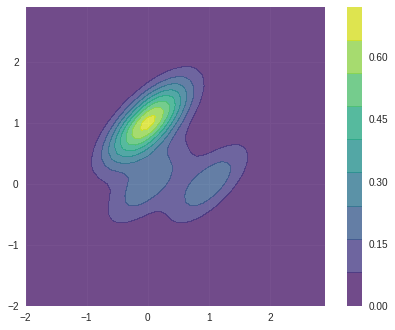

In [38]:
plot_2d_prob_density(x1,x2,pi)

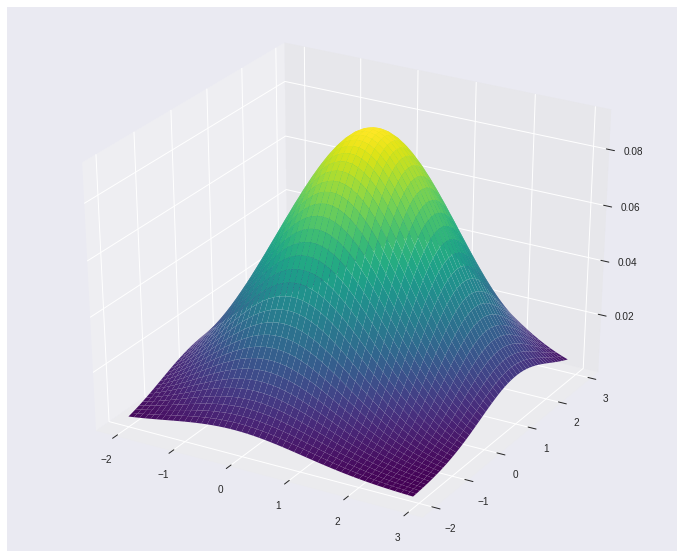

In [130]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2,pvs[2], cmap=plt.cm.viridis, linewidth=0.2);

In [799]:
# import plotly.plotly as py
# import plotly.graph_objs as go

# data = [
#     go.Surface(
#         x = x1,
#         y = x2,
#         z=pv,
#         colorscale='Viridis'
#     )
# ]
# layout = go.Layout(
#     autosize= True,
#     width=800,
#     height=600,
#      xaxis=dict(
#         showgrid=True
#     ),
#     yaxis=dict(
#         showgrid=True
#     )
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='prob-est-3d-surface')

In [800]:
# import plotly.plotly as py
# import plotly.graph_objs as go

# data = [
#     go.Surface(
#         x = x1,
#         y = x2,
#         z=pi,
#         colorscale='Viridis'
#     )
# ]
# layout = go.Layout(
#     autosize= True,
#     width=800,
#     height=600,
#      xaxis=dict(
#         showgrid=True
#     ),
#     yaxis=dict(
#         showgrid=True
#     )
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='prob-est-3d-surface')

***